In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
pip install xlrd


  Using cached xlrd-2.0.1-py2.py3-none-any.whl.metadata (3.4 kB)
Using cached xlrd-2.0.1-py2.py3-none-any.whl (96 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [7]:
# Load the Excel file
df = pd.read_excel('C:/Users/Galindo/Desktop/Energy_consumption.xls', header=14)

# Remove the 'Unnamed: 3' column
df.drop(columns=['Unnamed: 3'], inplace=True)

# Check the column names
print(df.columns)

# Check for null values
print(df.isnull().sum())

print(df)


Index(['Date', 'Hour', 'Q-Enginyeria-Total [kWh]'], dtype='object')
Date                        0
Hour                        0
Q-Enginyeria-Total [kWh]    0
dtype: int64
                     Date                Hour  Q-Enginyeria-Total [kWh]
0     2018-01-01 00:00:00 2018-01-01 00:00:00                177.000000
1     2018-01-01 01:00:00 2018-01-01 01:00:00                177.440000
2     2018-01-01 02:00:00 2018-01-01 02:00:00                176.570000
3     2018-01-01 03:00:00 2018-01-01 03:00:00                174.980000
4     2018-01-01 04:00:00 2018-01-01 04:00:00                174.510000
...                   ...                 ...                       ...
53624 2024-02-13 08:00:00 2024-02-13 08:00:00                363.222567
53625 2024-02-13 09:00:00 2024-02-13 09:00:00                388.690476
53626 2024-02-13 10:00:00 2024-02-13 10:00:00                417.800000
53627 2024-02-13 11:00:00 2024-02-13 11:00:00                440.495455
53628 2024-02-13 12:00:00 2024-02-13 

In [ ]:
# VISUALIZATION BASED ON MEANS

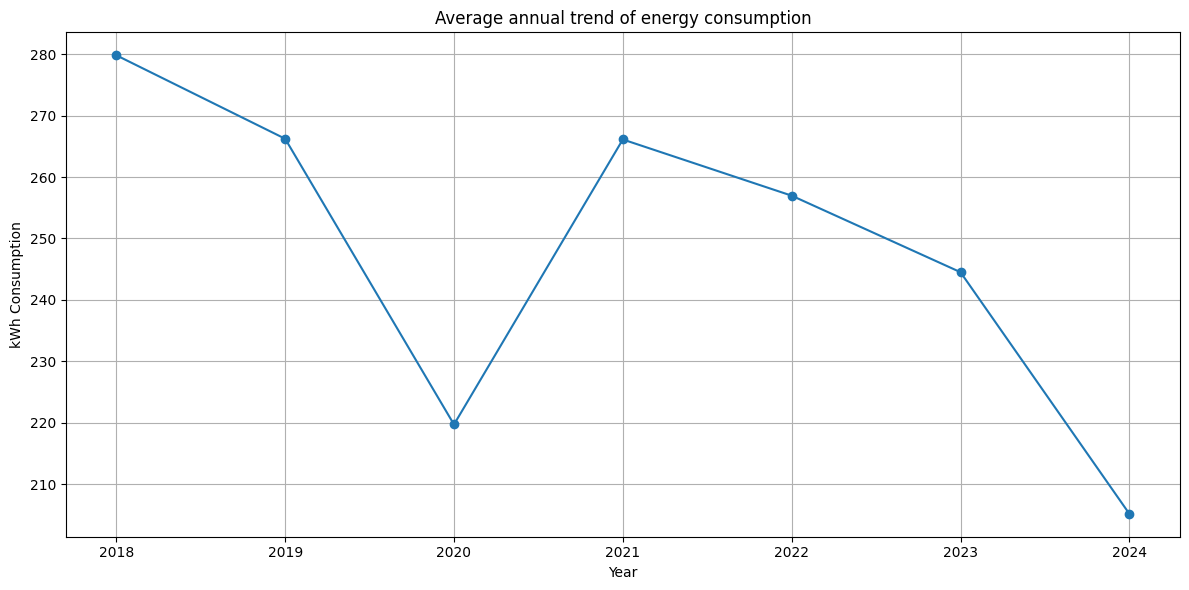

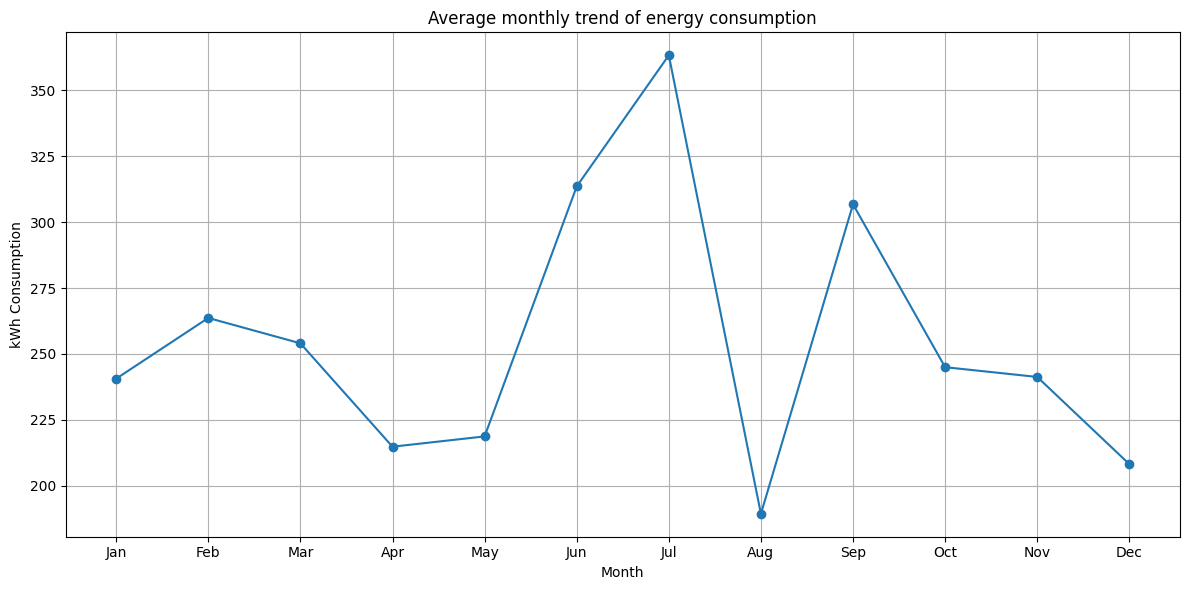

In [8]:
# Calculate the average kWh consumption per year and per month
yearly_consumption = df.groupby(df['Date'].dt.year)['Q-Enginyeria-Total [kWh]'].mean()
monthly_consumption = df.groupby(df['Date'].dt.month)['Q-Enginyeria-Total [kWh]'].mean()

# Visualization of average annual trend
plt.figure(figsize=(12, 6))
yearly_consumption.plot(marker='o', linestyle='-')
plt.title('Average annual trend of energy consumption')
plt.xlabel('Year')
plt.ylabel('kWh Consumption')
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualization of average monthly trend
plt.figure(figsize=(12, 6))
monthly_consumption.plot(marker='o', linestyle='-')
plt.title('Average monthly trend of energy consumption')
plt.xlabel('Month')
plt.ylabel('kWh Consumption')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()
plt.show()


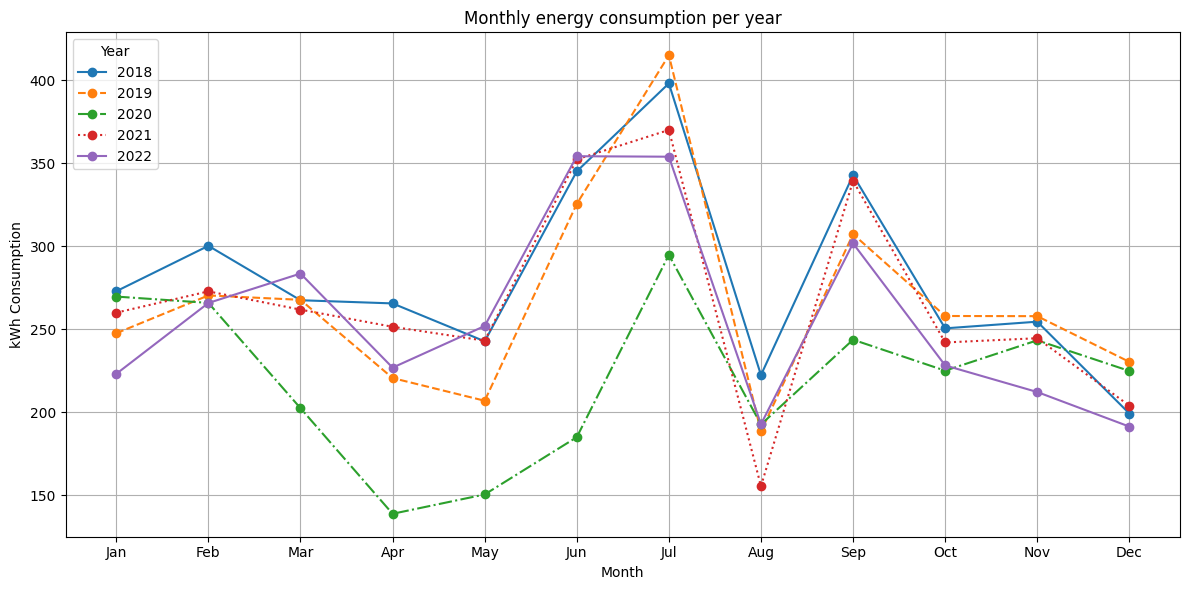

In [9]:
# Colors for each line
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

# Line style and markers
line_styles = ['-', '--', '-.', ':', '-']

# Calculate the average kWh consumption per month and per year
yearly_monthly_consumption = df.groupby([df['Date'].dt.year, df['Date'].dt.month])['Q-Enginyeria-Total [kWh]'].mean().unstack()

# Transpose the data to have years as columns and months as rows
yearly_monthly_consumption = yearly_monthly_consumption.T

# Visualization of the comparison of monthly energy consumption between different years
plt.figure(figsize=(12, 6))
for i, (year, color, line_style) in enumerate(zip(yearly_monthly_consumption.columns, colors, line_styles)):
    plt.plot(yearly_monthly_consumption.index, yearly_monthly_consumption[year], marker='o', linestyle=line_style, color=color, label=year)

plt.title('Monthly energy consumption per year')
plt.xlabel('Month')
plt.ylabel('kWh Consumption')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.legend(title='Year', loc='upper left')
plt.tight_layout()
plt.show()


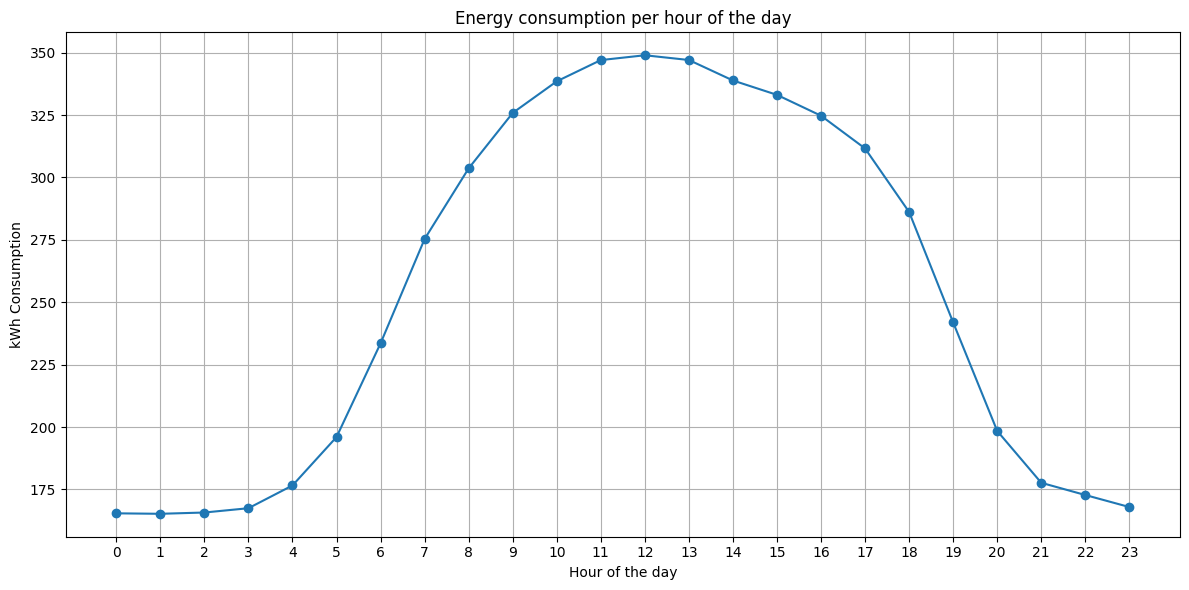

In [10]:
# Calculate the average kWh consumption per hour of the day
hourly_consumption = df.groupby(df['Date'].dt.hour)['Q-Enginyeria-Total [kWh]'].mean()

# Visualization of energy consumption per hour of the day
plt.figure(figsize=(12, 6))
hourly_consumption.plot(marker='o', linestyle='-')
plt.title('Energy consumption per hour of the day')
plt.xlabel('Hour of the day')
plt.ylabel('kWh Consumption')
plt.xticks(range(24))
plt.grid(True)
plt.tight_layout()
plt.show()


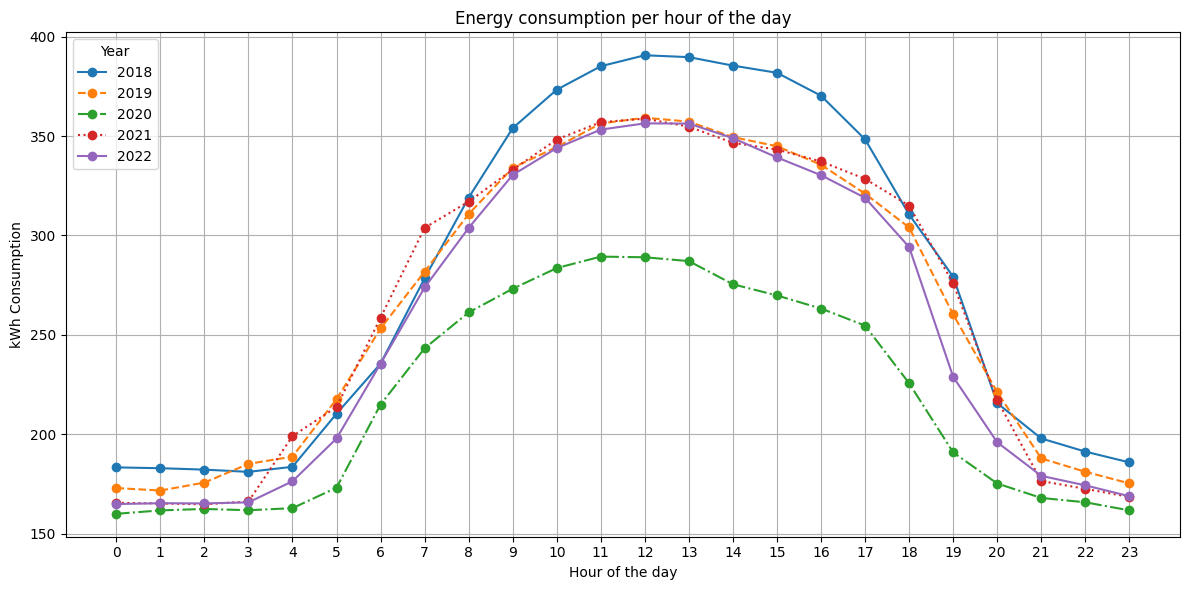

In [11]:
# Calculate the average kWh consumption per hour of the day
hourly_consumption = df.groupby([df['Date'].dt.year, df['Date'].dt.hour])['Q-Enginyeria-Total [kWh]'].mean().unstack()

# Transpose the data to have years as columns and hours as rows
hourly_consumption = hourly_consumption.T

# Colors for each line
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

# Line style and markers
line_styles = ['-', '--', '-.', ':', '-']

# Visualization of energy consumption per hour of the day
plt.figure(figsize=(12, 6))
for i, (year, color, line_style) in enumerate(zip(hourly_consumption.columns, colors, line_styles)):
    plt.plot(hourly_consumption.index, hourly_consumption[year], marker='o', linestyle=line_style, color=color, label=year)

plt.title('Energy consumption per hour of the day')
plt.xlabel('Hour of the day')
plt.ylabel('kWh Consumption')
plt.xticks(range(24))
plt.grid(True)
plt.legend(title='Year', loc='upper left')
plt.tight_layout()
plt.show()


FORECASTING

In [12]:

# Assuming 'Date' and 'Hour' are separate or not properly formatted as datetime
df['Date'] = pd.to_datetime(df['Date'])  # Converts column to datetime

# Display the first few rows of the dataframe
df.head()


,Date,Hour,Q-Enginyeria-Total [kWh]
0,2018-01-01 00:00:00,2018-01-01 00:00:00,177.00
1,2018-01-01 01:00:00,2018-01-01 01:00:00,177.44
2,2018-01-01 02:00:00,2018-01-01 02:00:00,176.57
3,2018-01-01 03:00:00,2018-01-01 03:00:00,174.98
4,2018-01-01 04:00:00,2018-01-01 04:00:00,174.51


In [13]:
# Set datetime as the index of the dataframe
df.index = pd.to_datetime(df['Date'])
df.drop(['Date', 'Hour'], axis=1, inplace=True)  # Drop redundant columns if necessary

# Check the head of the dataframe to confirm changes
print(df.head())


                     Q-Enginyeria-Total [kWh]
Date                                         
2018-01-01 00:00:00                    177.00
2018-01-01 01:00:00                    177.44
2018-01-01 02:00:00                    176.57
2018-01-01 03:00:00                    174.98
2018-01-01 04:00:00                    174.51


In [18]:
pip install scikit-learn

     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.6 kB ? eta -:--:--
     ---------------------------------------- 60.6/60.6 kB 1.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/10.6 MB 4.5 MB/s eta 0:00:03
   - -------------------------------------- 0.5/10.6 MB 4.9 MB/s eta 0:00:03
   ------- -------------------------------- 2.1/10.6 MB 14.7 MB/s eta 0:00:01
   ---------------- ----------------------- 4.4/10.6 MB 23.3 MB/s eta 0:00:01
   ---------------------------- ----------- 7.6/10.6 MB 32.3 MB/s eta 0:00:01
   ----------------------------------- ---- 9.4/10.6 MB 37.5 MB/s eta 0:00:01
   ----------------------------------- ---- 9.4/10.6 MB 33.5 MB/s eta 0:00:01
   ------------------------------------ --- 9.8/10.6 MB 27.2 MB/s eta 0:00:01
   ---------------------------------------  10.4/10.6 MB 29.8 MB/s eta 0:00:01
   -

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values.reshape(-1, 1))

# Optionally convert back to dataframe for easier handling
data_scaled = pd.DataFrame(data_scaled, index=df.index, columns=['Energy'])


In [29]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 360  # use the last 24 hours to predict the next hour
X, Y = create_dataset(data_scaled.values, look_back)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


In [30]:
# Splitting the dataset into training and testing sets
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]


In [31]:
# Define the model
model = Sequential()

# Adding the LSTM layer:
# - units: the dimensionality of the output space
# - return_sequences: True if another LSTM layer follows
# - input_shape: shape of the input. Only necessary for the first layer.
model.add(LSTM(units=50, return_sequences=True, input_shape=(None, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Output layer, 1 unit for output

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


c:\Users\Galindo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=40, batch_size=32)


Epoch 1/40
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 116s 102ms/step - loss: 0.0081 - val_loss: 0.0019
Epoch 2/40
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 103s 92ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 3/40
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 110s 99ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 4/40
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 115s 103ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 5/40
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 113s 101ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 6/40
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 120s 107ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/40
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 119s 106ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 8/40
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 119s 107ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 9/40
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 120s 107ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 10/40
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 118s 106ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 11/40
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 120s 108ms/step - loss: 0.0010 - val_l

In [33]:
import math
from sklearn.metrics import mean_squared_error
# Example of making predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

# Inverse transformation for original scale values
trainPredict = scaler.inverse_transform(trainPredict)
Y_train_inv = scaler.inverse_transform([Y_train])
testPredict = scaler.inverse_transform(testPredict)
Y_test_inv = scaler.inverse_transform([Y_test])

# Calculate RMSE
trainScore = math.sqrt(mean_squared_error(Y_train_inv[0], trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(Y_test_inv[0], testPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))


1116/1116 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step
550/550 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step
Train Score: 24.15 RMSE
Test Score: 25.99 RMSE


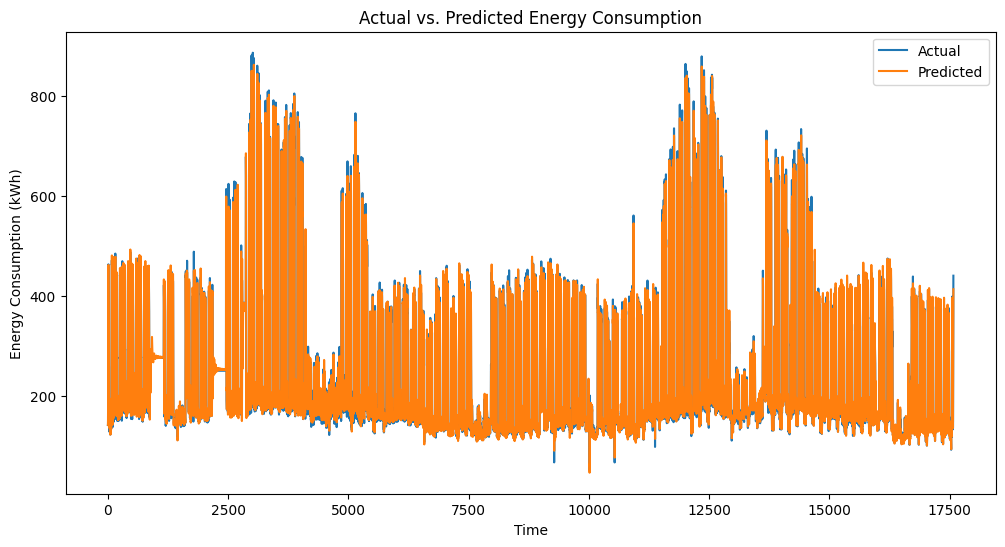

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(Y_test_inv[0], label='Actual')
plt.plot(testPredict[:,0], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Actual vs. Predicted Energy Consumption')
plt.legend()
plt.show()


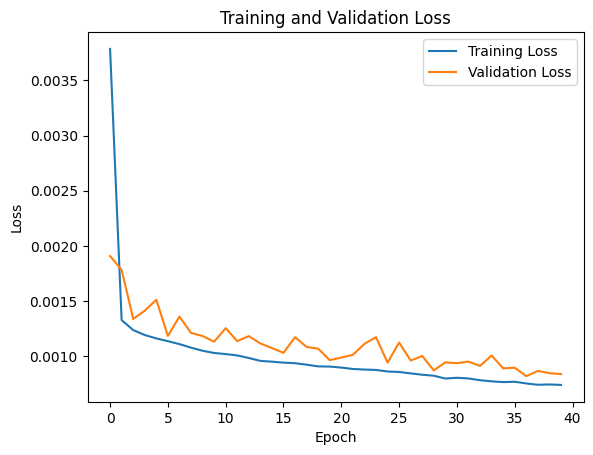

In [35]:

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


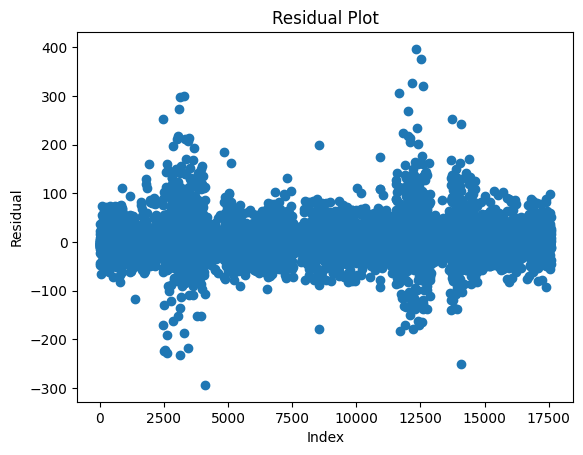

In [36]:
# Plotting the residuals (the differences between actual and predicted values) can help identify patterns or biases in your model's predictions.
residuals = Y_test_inv[0] - testPredict[:,0]
plt.scatter(range(len(residuals)), residuals)
plt.xlabel('Index')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.show()


In [37]:
import pandas as pd
import numpy as np

# Generate timestamps for the next 7 days
future_dates = pd.date_range(start='2024-02-13', periods=24*7, freq='H')

# Reshape the data for the next 7 days
future_data = []

for i in range(len(future_dates)):
    # Extract historical data leading up to each future date
    historical_data = data_scaled.loc[:future_dates[i]]
    if len(historical_data) < look_back:
        # If there's not enough historical data, pad with zeros
        pad_size = look_back - len(historical_data)
        historical_data = np.concatenate([np.zeros((pad_size, 1)), historical_data])
    else:
        historical_data = historical_data[-look_back:]
    # Reshape the historical data to match the input shape of the model
    input_data = np.reshape(historical_data, (1, look_back, 1))
    future_data.append(input_data)

# Concatenate all future data
future_data = np.concatenate(future_data)

# Make predictions for the next 7 days
predicted_values = model.predict(future_data)

# Inverse transform the predicted values to the original scale
predicted_values_original_scale = scaler.inverse_transform(predicted_values)

# Print predicted values for each future date
for i, timestamp in enumerate(future_dates):
    print("Predicted energy consumption for", timestamp, ":", predicted_values_original_scale[i][0])


5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

C:\Users\Galindo\AppData\Local\Temp\ipykernel_24496\2625262744.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start='2024-02-13', periods=24*7, freq='H')


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted energy consumption for 2024-02-13 00:00:00 : 141.28697
Predicted energy consumption for 2024-02-13 01:00:00 : 143.96526
Predicted energy consumption for 2024-02-13 02:00:00 : 149.96059
Predicted energy consumption for 2024-02-13 03:00:00 : 182.36473
Predicted energy consumption for 2024-02-13 04:00:00 : 209.48691
Predicted energy consumption for 2024-02-13 05:00:00 : 229.57658
Predicted energy consumption for 2024-02-13 06:00:00 : 315.48132
Predicted energy consumption for 2024-02-13 07:00:00 : 345.8453
Predicted energy consumption for 2024-02-13 08:00:00 : 380.4236
Predicted energy consumption for 2024-02-13 09:00:00 : 395.57986
Predicted energy consumption for 2024-02-13 10:00:00 : 413.40604
Predicted energy consumption for 2024-02-13 11:00:00 : 425.96878
Predicted energy consumption for 2024-02-13 12:00:00 : 229.85126
Predicted energy consumption for 2024-02-13 13:00:00 : 229.85126
Predicted energy consumption for 2024-02-13 14:00:00 :